# RNN Bible Generator

Notebook adapted from the [Shakespeare Text Generation (using RNN LSTM)](https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb) notebook.  
Modified by: Gábor Major  
Last Modified date: 2025-03-21

Import libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.10.6
Tensorflow version: 2.9.1
Keras version: 2.9.0


## Load in Data
The English Revised Version of the Bible was used which was downloaded from [Open Bible](https://openbible.com/texts.htm).  
The Bible downloaded as a TXT file has 31,102 lines of text, with the specific section of the Bible the quote is from at the start of each line.

In [2]:
# Encoding needed to remove \ufeff character
with open('erv_bible.txt', 'r',encoding='utf-8-sig') as f:
    bible_text = f.read()

## Analyse Data

In [3]:
print(f'Length of text: {len(bible_text)} characters')
# Take a look at the first 250 characters in text.
print(bible_text[:250])

Length of text: 4568142 characters
Genesis 1:1	In the beginning God created the heaven and the earth.
Genesis 1:2	And the earth was waste and void; and darkness was upon the face of the deep: and the spirit of God moved upon the face of the waters.
Genesis 1:3	And God said, Let there 


In [4]:
# The unique characters in the file
vocabulary = sorted(set(bible_text))

print(f'{len(vocabulary)} unique characters')
print('Vocabularly:', vocabulary)

76 unique characters
Vocabularly: ['\t', '\n', ' ', '!', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '’']


## Process Data
All of the text must be converted into a sequence of numbers for the model.

In [5]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocabulary)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\t':   0,
  '\n':   1,
  ' ' :   2,
  '!' :   3,
  '(' :   4,
  ')' :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '0' :   9,
  '1' :  10,
  '2' :  11,
  '3' :  12,
  '4' :  13,
  '5' :  14,
  '6' :  15,
  '7' :  16,
  '8' :  17,
  '9' :  18,
  ':' :  19,
  ...
}


In [6]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocabulary)
print(index2char)

['\t' '\n' ' ' '!' '(' ')' ',' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7' '8'
 '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N'
 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'Y' 'Z' '_' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z' '—' '’']


In [7]:
# Convert characters in text to indices.
text_as_int = np.array([char2index[char] for char in bible_text])

print(f'text_as_int length: {len(text_as_int)}')
print(f'{repr(bible_text[:15])} --> {repr(text_as_int[:15])}')

text_as_int length: 4568142
'Genesis 1:1\tIn ' --> array([28, 52, 61, 52, 66, 56, 66,  2, 10, 19, 10,  0, 30, 61,  2])


## Create Training Sequences

In [8]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 120
examples_per_epoch = len(bible_text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 37753


In [9]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

G
e
n
e
s


In [10]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print(f'Sequences count: {len(list(sequences.as_numpy_iterator()))}');
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 37753

'Genesis 1:1\tIn the beginning God created the heaven and the earth.\nGenesis 1:2\tAnd the earth was waste and void; and dark'
'ness was upon the face of the deep: and the spirit of God moved upon the face of the waters.\nGenesis 1:3\tAnd God said, Le'
't there be light: and there was light.\nGenesis 1:4\tAnd God saw the light, that it was good: and God divided the light fro'
'm the darkness.\nGenesis 1:5\tAnd God called the light Day, and the darkness he called Night. And there was evening and the'
're was morning, one day.\nGenesis 1:6\tAnd God said, Let there be a firmament in the midst of the waters, and let it divide'


Duplicate and shift each sequence to create the target output.

In [11]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [12]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print(f'Dataset size: {len(list(dataset.as_numpy_iterator()))}')

Dataset size: 37753


In [13]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 120
Target sequence size: 120

Input: 'Genesis 1:1\tIn the beginning God created the heaven and the earth.\nGenesis 1:2\tAnd the earth was waste and void; and dar'
Target: 'enesis 1:1\tIn the beginning God created the heaven and the earth.\nGenesis 1:2\tAnd the earth was waste and void; and dark'


Model is trained as follows at each step.

In [14]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print(f'Step {i}')
    print(f'  input: {input_idx} ({index2char[input_idx]})')
    print(f'  expected output: {target_idx} ({index2char[target_idx]})')

Step 0
  input: 28 (G)
  expected output: 52 (e)
Step 1
  input: 52 (e)
  expected output: 61 (n)
Step 2
  input: 61 (n)
  expected output: 52 (e)
Step 3
  input: 52 (e)
  expected output: 66 (s)
Step 4
  input: 66 (s)
  expected output: 56 (i)


## Split into Batches
Split the training sequences into batches, and shuffle them.

In [15]:
# Batch size.
BATCH_SIZE = 2048

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [16]:
print(f'Batched dataset size: {len(list(dataset.as_numpy_iterator()))}')

Batched dataset size: 18


In [17]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[61 51 19 ...  2 48 54]
 [ 2 62 61 ... 70 52 61]
 [56 59 52 ...  1 31 68]
 ...
 [ 6  2 67 ... 72  2 10]
 [25  6  2 ... 36 39 25]
 [55 52  2 ... 56 67 55]], shape=(2048, 120), dtype=int32)

1st batch: target_text: tf.Tensor(
[[51 19  2 ... 48 54 48]
 [62 61 52 ... 52 61 67]
 [59 52 48 ... 31 68 51]
 ...
 [ 2 67 55 ...  2 10 17]
 [ 6  2 48 ... 39 25  2]
 [52  2 33 ... 67 55 52]], shape=(2048, 120), dtype=int32)


## Build the Model
Model consits of a Sequential model, with 3 layers.  
Embedding Layer, used for input and as a lookup table.  
LSTM Layer, core of the model, the RNN.  
Dense Layer, used for the output.

In [18]:
# Length of the vocabulary in characters.
vocabulary_size = len(vocabulary)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [19]:
def build_model(vocabulary_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocabulary_size))
  
    return model

In [20]:
model = build_model(vocabulary_size, embedding_dim, rnn_units, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (2048, None, 256)         19456     
                                                                 
 lstm (LSTM)                 (2048, None, 1024)        5246976   
                                                                 
 dense (Dense)               (2048, None, 76)          77900     
                                                                 
Total params: 5,344,332
Trainable params: 5,344,332
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [21]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(2048, 120, 76) # (batch_size, sequence_length, vocab_size)


In [22]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocabulary_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (2048, 120, 76)  # (batch_size, sequence_length, vocabulary_size)
scalar_loss:       4.33192


In [23]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)
epochs = 10

In [24]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [25]:
history = model.fit(
  x=dataset,
  epochs=epochs,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/10
18/18 [==============================] - 264s 15s/step - loss: 3.3837
Epoch 2/10
18/18 [==============================] - 264s 15s/step - loss: 3.0625
Epoch 3/10
18/18 [==============================] - 263s 15s/step - loss: 2.7422
Epoch 4/10
18/18 [==============================] - 263s 15s/step - loss: 2.4028
Epoch 5/10
18/18 [==============================] - 263s 15s/step - loss: 2.2202
Epoch 6/10
18/18 [==============================] - 262s 15s/step - loss: 2.0919
Epoch 7/10
18/18 [==============================] - 263s 15s/step - loss: 1.9834
Epoch 8/10
18/18 [==============================] - 263s 15s/step - loss: 1.8883
Epoch 9/10
18/18 [==============================] - 263s 15s/step - loss: 1.8009
Epoch 10/10
18/18 [==============================] - 262s 15s/step - loss: 1.7153


In [26]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

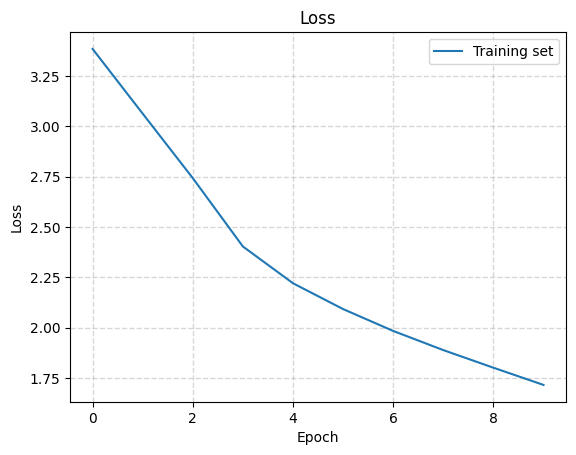

In [27]:
render_training_history(history)

Restore last checkpoint to change batch_size to 1.

In [28]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints\\ckpt_10'

In [29]:
simplified_batch_size = 1

model = build_model(vocabulary_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([simplified_batch_size, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            19456     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 76)             77900     
                                                                 
Total params: 5,344,332
Trainable params: 5,344,332
Non-trainable params: 0
_________________________________________________________________


## Generate Text

In [30]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [31]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"Jesus: "))

Jesus: 55	OL	O0	Affrith in the dard offremen; ind uplahninad; atder fas wis sonctoop this that tron whines the wall ond noupe of merin; and thao shill youg? ind to doelt, they foreded: Jecoughous int thears of Saroms.
Mout 115:2	As upeint inatianf of the brangstrongsh of foo them becess comne has cwater.
Detian 1:13	Mowein, bat pathunger affore; sais, thou servet not forery, and cerdining athernele, aul greming int the ringrongs not unto me, at mey gime of the pertur colamanitine limy pastlesings welclet the ladsato thes, not the ball chasservany shall bee ineled all repeshels.
Jocmutious 11:1	notery, anr the bladstreds; and the fordin.
2 Corintist 22:10	Betwiry lough thare vere of in Godwtitice ferom unto them houds, Jold whelhed in the wound of all the prictiting of and dave forings: theigher is lidgelt, watt he seath to his wrindenatto nou efterd with no me damo in mang.
Pstacake 1:37	Hunglith his corsifstolloy un, wild deeg, youutat the clidsthuren, Heavent and the heoram, For hise

In [40]:
# Generate the text with lower temperature to get more readable results.
print(generate_text(model, start_string=u"Jesus: ", temperature=0.48))

Jesus: Chrill shall be the king of the wither of the LORD.
Jukn 1:15	And whou shall be were be the shald of Israel be the came of the right of the hither shall be not shall be for the wouss, be so did of the LORD his heard not said unto the mand of the came of the ear of the sent of the belle, which the wers of the taing of the LORD have saing him that waid shall be be anderinged the plipst of the LORD and he paking of the mand of the couns of the wints in the LORD that I will not the ward with the king.
Psalm 16:13	And the hild of the prest of the LORD the sang of the seaples of his death.
2 Chronicles 11:2	And is shall be wist the LORD, and the ball of the sand of the son on the ford and the hime of the said of the that the touph of the brong of the LORD the LORD wert be and of his saing, that we the wild of the clace unto the mond of the with of the hald taid the douth the sont of the mand of the say of the seat, which came the things of the serich, and alle the brothe whill be whil

## Save Model

In [33]:
model.save('rnn_bible.keras')